In [146]:
from __future__ import absolute_import, division, print_function
from builtins import (
    ascii, bytes, chr, dict, filter, hex, input, int, map,
    next, oct, open, pow, range, round, str, super, zip)

import os
from itertools import cycle
from functools import partial
import random
from math import pi

from osgeo import ogr, gdal
import osr
import pyproj
import psycopg2
from shapely.geometry import shape, MultiPolygon
from shapely.ops import transform
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.colors import to_rgb
from matplotlib.patches import Polygon
%matplotlib inline

In [2]:
psql_pass = os.environ['PSQL_PASS']

In [3]:
conn = psycopg2.connect(
    database='wisc_gerry',
    user='pmende',
    password=psql_pass,
    host='localhost'
)

In [7]:
cur = conn.cursor()

In [77]:
cong_shp_file = 'data/districts/congressional/Wisconsin_Congressional_Districts.shp'

In [99]:
driver = ogr.GetDriverByName('ESRI Shapefile')

In [132]:
inSpatialRef = osr.SpatialReference()
inSpatialRef.ImportFromEPSG(4326)
outSpatialRef = osr.SpatialReference()
outSpatialRef.ImportFromEPSG(3695)
coord_transform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

In [141]:
cong_shapes = driver.Open(cong_shp_file, 0)
cong_layer = cong_shapes.GetLayer()
cong_layer.CreateField(new_field)
for feature in cong_layer:
    geom = feature.GetGeometryRef()
    geom.Transform(coord_transform)
    poly = ogr.Geometry(ogr.wkbPolygon)
    poly.AddGeometry(geom)
    blah = shape(poly.ExportToJson())
    area = geom.Area()
    perimeter = geom.Boundary().Length()
    ratio = 4*pi*area/perimeter**2
    print('area (km^2): ', area/(1000)**2)
    print('perimeter (km): ', perimeter/1000)
    print('A/C^2: ', ratio)
    print('~~~~~~')

AttributeError: 'str' object has no attribute 'get'

In [152]:
project = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), 
    pyproj.Proj(init='epsg:3695')
)

with fiona.open(cong_shp_file) as f:
    districts = [
        {
            'shape': transform(project, shape(polygon['geometry'])), 
             'District': polygon['properties']['District_N']
        }
        for polygon in f
    ]

for district in districts:
    district['area'] = district['shape'].area/(1000)**2
    district['perimeter'] = district['shape'].length/1000

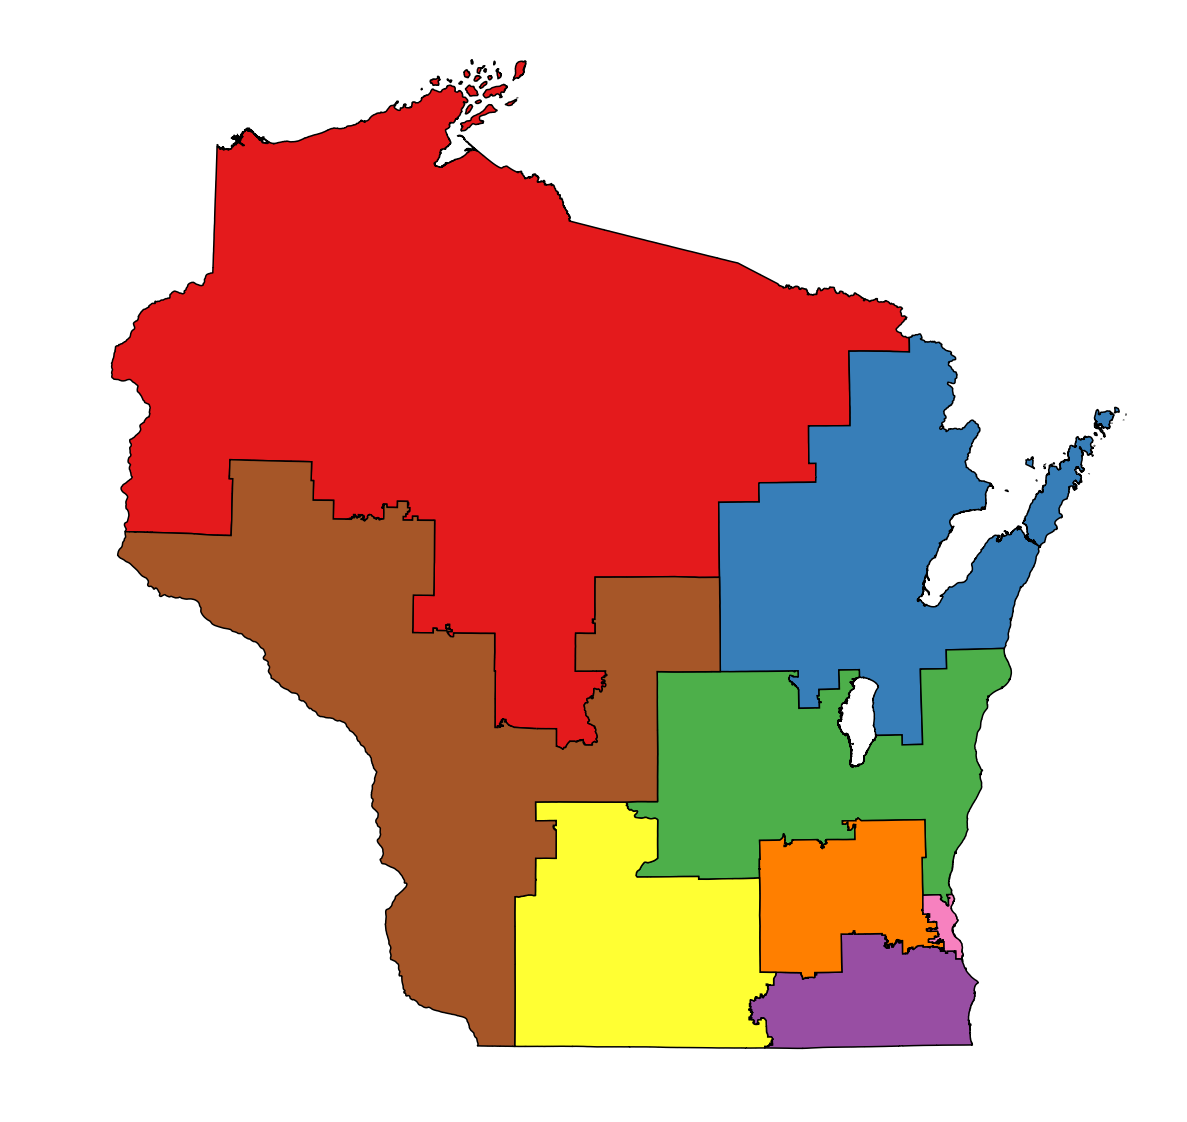

In [151]:
congressional_patches = [
    PolygonPatch(dis['shape'])
    for dis in districts
]

hex_colors = [
    '#e41a1c', '#377eb8', '#4daf4a', '#984ea3',
    '#ff7f00', '#ffff33', '#a65628', '#f781bf'
]
colors = [to_rgb(color) for color in hex_colors]
for patch, color in zip(congressional_patches, cycle(colors)):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

fig, ax = plt.subplots(figsize=(20,20))

for patch in congressional_patches:
    ax.add_patch(patch)
    
ax.relim()
ax.autoscale_view()
ax.axis('off');

In [89]:
fig.savefig('images/congressional_districts.png', bbox_inches='tight')

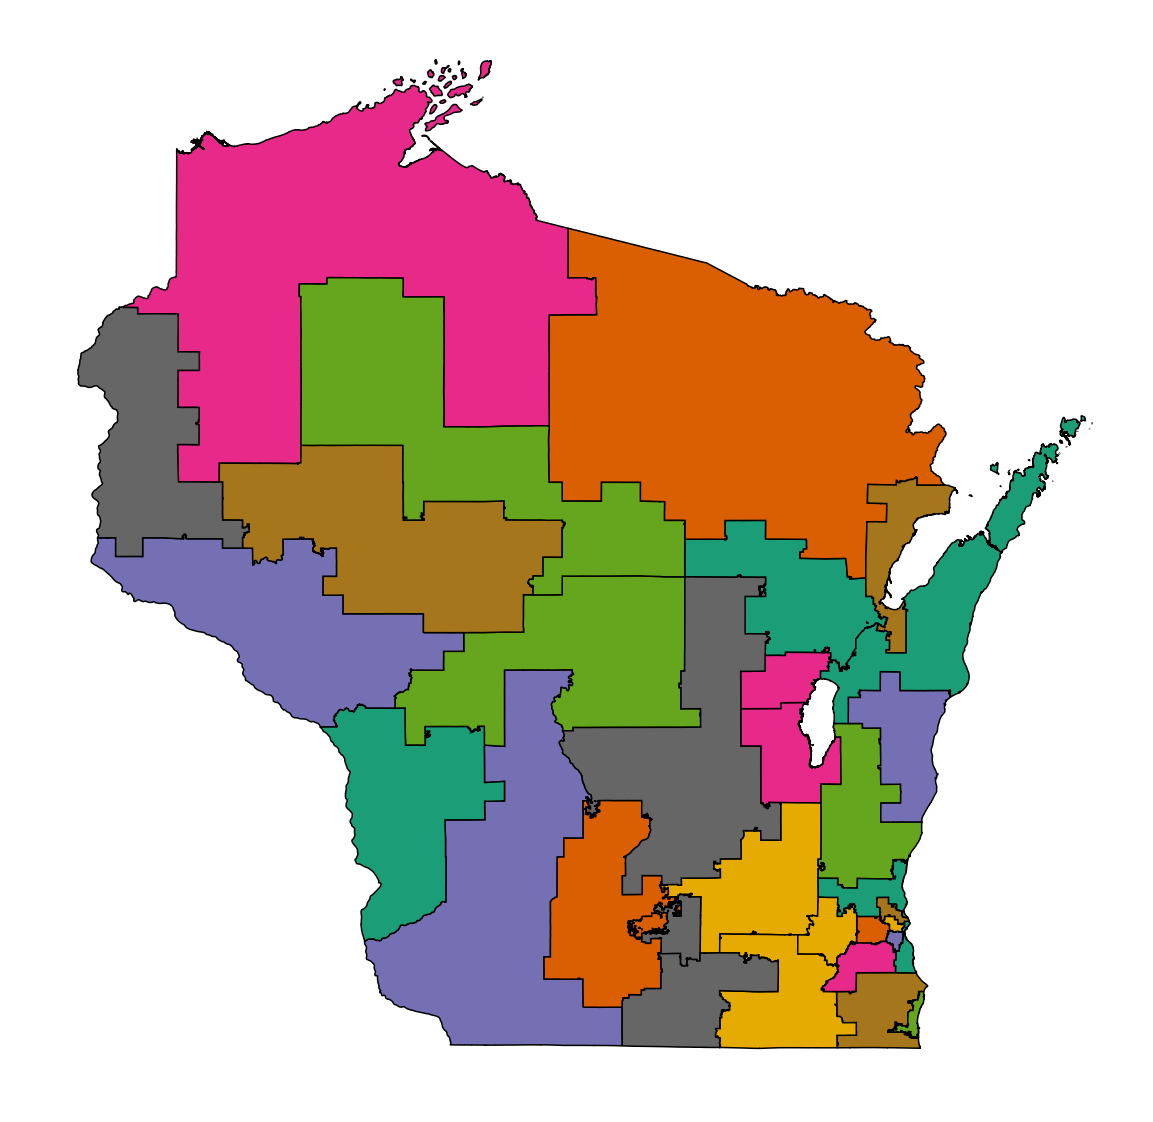

In [19]:
with fiona.open('data/districts/state_senate/Wisconsin_State_Senate_Districts.shp') as f:
    shapes = [shape(polygon['geometry']) for polygon in f]
    patches = [PolygonPatch(shp) for shp in shapes]

random.seed(38502)
random.shuffle(patches)
N = 8
colors = [plb.cm.Dark2(x) for x in range(N)]
for patch, color in zip(patches, cycle(colors)):
    patch.set_facecolor(color)
    patch.set_linewidth(1.5)

fig, ax = plt.subplots(figsize=(20,20))

for patch in patches:
    ax.add_patch(patch)
    
ax.relim()
ax.autoscale_view()
ax.axis('off');